# Datasets:

* pca_ba_robust_example.csv and pca_ba_robust_example: 10 different BA(300, m=3) networks, all methods, 250 runs, sample sizes = [0.1, 0.25, 0.4]; 
* ba_robust_single.csv and pca_ ba_robust_single.csv: 10 different BA(500, m=3) networks, all methods, 1000 runs, sample sizes = [0.2]; 
* pca_er_robust_example.csv and pca_er_robust_example: 10 different ER(300, p=0.3) networks, all methods, 250 runs, sample sizes = [0.1, 0.25, 0.4]; 
* pca_sw_robust_example.csv and pca_sw_robust_example: 10 different SW(n=300, k=10, p=0.4) networks, all methods, 250 runs, sample sizes = [0.1, 0.25, 0.4]; 
* pca_meier_robust_example.csv and pca_meier_robust_example: Maier network largest components decreased of 29 nodes (connected graph with 300 nodes total), all methods, 2500 runs, sample sizes = [0.1, 0.25, 0.4]; 


# Ideas:

* Graph of train vs test combinations (nodes are data subsets and sizes and links are performances). Test all possible subsets.
* The minimum size of a sampled network that results in considerable discrimination performance between methods.
* See metrics that have the least shap values to discriminate between methods in comparison to the metrics that have the largest. 
* Copare all methods two by two in all possible combinations 

# Observations and conclusions:

* The IRWS method follows a budget rule that is unfair in relation to other methods, but the other link tracing methods are not that different in edge count and the comparison is more fair.

In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import random as rd
import math
import altair as alt

from scipy.stats import entropy
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

In [5]:
import catboost
import shap
import sklearn

In [4]:
data_ba = pd.read_csv('../2_multivariate_analysis/data/pca_ba_robust_example.csv')

data_er = pd.read_csv('../2_multivariate_analysis/data/pca_er_robust_example.csv')

data_sw = pd.read_csv('../2_multivariate_analysis/data/pca_sw_robust_example.csv')

data_maier = pd.read_csv('../2_multivariate_analysis/data/pca_meier_robust_example.csv')

In [5]:
data = pd.concat([data_ba, data_er, data_sw, data_maier], axis=0)

In [6]:
#data = pd.read_csv('../2_multivariate_analysis/data/pca_meier_robust_example.csv')

In [7]:
data.head()

,Assortativity,Transitivity,Av. shortest p.,Complexity Coef,1m Degree,2m Degree,3m Degree,4m Degree,H Degree,1m L. clustering,...,2m Eigenvector,3m Eigenvector,4m Eigenvector,H Eigenvector,len,method,net id,Component0,Component1,Component2
0,-0.108169,0.044497,3.043032,11.820426,5.940000,70.213333,1724.460000,62876.293333,0.882092,0.079138,...,0.003333,0.000560,0.000148,0.099845,300,Original,0,-1.803036,0.775470,-0.502186
1,-0.749980,0.012766,2.600000,7.911765,2.266667,17.933333,267.066667,4648.333333,0.412403,0.013624,...,0.033333,0.012106,0.006090,0.406351,30,SB,0,1.041244,0.806296,0.595316
2,-0.402381,0.000000,5.241379,2.354839,2.066667,4.866667,13.266667,42.466667,0.412998,0.000000,...,0.033333,0.011679,0.004971,0.523663,30,RWS,0,1.057162,-0.066579,-0.421944
3,-0.075121,0.199052,2.682759,4.981132,3.533333,17.600000,112.533333,865.200000,0.839682,0.118124,...,0.033333,0.009880,0.003451,0.555322,30,IRWS,0,0.187667,1.189324,-1.029855
4,-0.059827,0.072289,3.618391,3.515152,2.200000,7.733333,41.400000,286.933333,0.573639,0.019630,...,0.033333,0.012159,0.005249,0.500939,30,TR,0,1.003363,0.290941,-0.099918


In [8]:
data.shape

(150031, 50)

In [97]:
method0 = 'MHRW'
method1 = 'RWS' 

In [98]:
subpop_data = data[(data['method']==method0) | (data['method']==method1)].copy()
#subpop_data = data
#subpop_data = subpop_data[subpop_data['len']==75]

In [99]:
subpop_data['indicator'] = subpop_data['method'].apply(lambda x: 1 if x==method1 else 0)

In [100]:
subpop_data.head()

,Assortativity,Transitivity,Av. shortest p.,Complexity Coef,1m Degree,2m Degree,3m Degree,4m Degree,H Degree,1m L. clustering,...,3m Eigenvector,4m Eigenvector,H Eigenvector,len,method,net id,Component0,Component1,Component2,indicator
2,-0.402381,0.000000,5.241379,2.354839,2.066667,4.866667,13.266667,42.466667,0.412998,0.000000,...,0.011679,0.004971,0.523663,30,RWS,0,1.057162,-0.066579,-0.421944,1
5,-0.360000,0.066667,7.165517,2.500000,2.000000,5.000000,15.000000,51.800000,0.557803,0.047778,...,0.013213,0.005889,0.519189,30,MHRW,0,1.605829,-0.217669,-0.313648,0
7,-0.302521,0.000000,4.878161,2.516129,2.066667,5.200000,16.666667,68.000000,0.434069,0.000000,...,0.013919,0.007116,0.451833,30,RWS,0,0.998469,0.006564,-0.307298,1
10,-0.216783,0.000000,9.388506,2.068966,1.933333,4.000000,8.933333,22.000000,0.231897,0.000000,...,0.013470,0.006283,0.466632,30,MHRW,0,2.024716,-0.495085,-0.263695,0
12,-0.579425,0.000000,8.112644,2.275862,1.933333,4.400000,11.533333,34.000000,0.480870,0.000000,...,0.010560,0.004036,0.564874,30,RWS,0,1.827125,-0.426109,-0.262777,1


In [101]:
# X = subpop_data[['Assortativity', 'Complexity Coef', '1m Degree', '2m Degree', '3m Degree', '4m Degree', 'H Degree']]
# X = subpop_data[['Component0', 'Component1', 'Component2']]
X = subpop_data.drop(['Component0', 'Component1', 'Component2', 'net id', 'method', 'len', 'indicator'], axis=1)
y = subpop_data['indicator']

In [19]:
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool, cv
from sklearn.metrics import make_scorer, roc_auc_score

In [20]:
def gini_score(expected, predicted, **unused_kwargs) -> float:
    return abs(roc_auc_score(expected, predicted)-0.5)*2.0

In [104]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=2112)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=19)

In [105]:
train_pool = Pool(X_train, y_train)

In [106]:
model = CatBoostClassifier(
    thread_count=3,
    iterations=2000,
    learning_rate=.015,
    depth=5.0,
    l2_leaf_reg=0.550,
    min_child_samples=10.0,
    grow_policy='SymmetricTree',
    loss_function='Logloss',
    eval_metric='Logloss',
    # eval_metric='AUC:hints=skip_train~false',
    od_type='Iter',
    bootstrap_type='Bayesian',
    auto_class_weights='Balanced'
).fit(
    train_pool,
    early_stopping_rounds=100,
    eval_set=Pool(X_valid, y_valid),
    save_snapshot=False
)

0:	learn: 0.6904773	test: 0.6904922	best: 0.6904922 (0)	total: 20ms	remaining: 39.9s
1:	learn: 0.6879518	test: 0.6879801	best: 0.6879801 (1)	total: 39.4ms	remaining: 39.4s
2:	learn: 0.6854902	test: 0.6855346	best: 0.6855346 (2)	total: 60.3ms	remaining: 40.1s
3:	learn: 0.6831970	test: 0.6833046	best: 0.6833046 (3)	total: 81.9ms	remaining: 40.9s
4:	learn: 0.6810568	test: 0.6811701	best: 0.6811701 (4)	total: 102ms	remaining: 40.5s
5:	learn: 0.6788737	test: 0.6789743	best: 0.6789743 (5)	total: 123ms	remaining: 40.8s
6:	learn: 0.6766006	test: 0.6767221	best: 0.6767221 (6)	total: 141ms	remaining: 40s
7:	learn: 0.6745827	test: 0.6747046	best: 0.6747046 (7)	total: 159ms	remaining: 39.7s
8:	learn: 0.6725894	test: 0.6727700	best: 0.6727700 (8)	total: 177ms	remaining: 39s
9:	learn: 0.6706473	test: 0.6708455	best: 0.6708455 (9)	total: 195ms	remaining: 38.9s
10:	learn: 0.6688526	test: 0.6691379	best: 0.6691379 (10)	total: 220ms	remaining: 39.7s
11:	learn: 0.6670002	test: 0.6672968	best: 0.6672968 (

In [107]:
y_pred = np.round(model.predict_proba(X_test)[:, 1], 5)

In [108]:
gini_score(y_test, y_pred)

0.5633754950105403

In [109]:
roc_auc_score(y_test, y_pred)

0.7816877475052701

In [110]:
shap.initjs()

In [111]:
Xshap = pd.concat([
    X_test[y_test==0], 
    X_test[y_test==1]  
], axis=0).sample(frac=1)

In [112]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(Xshap)

In [113]:
shap_explanation = explainer(Xshap)

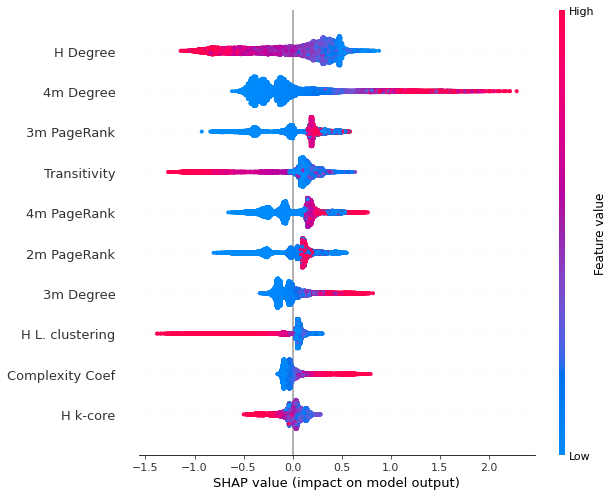

In [114]:
shap.summary_plot(shap_values, Xshap, plot_size=(9,7), show=False, max_display=10)
plt.tight_layout()
plt.show()

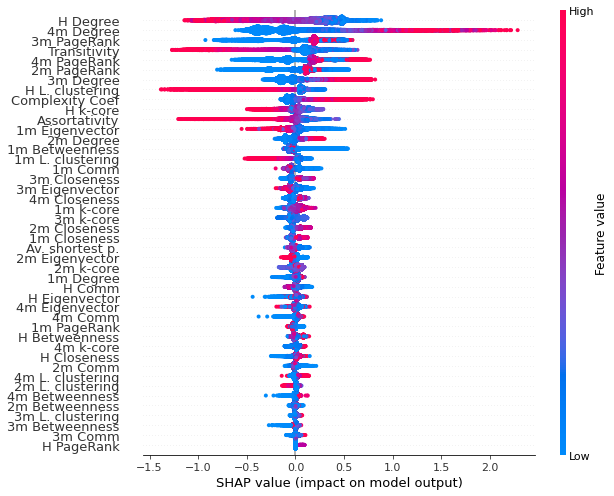

In [115]:
shap.summary_plot(shap_values, Xshap, plot_size=(9,7), show=False, max_display=100)
plt.tight_layout()
plt.show()

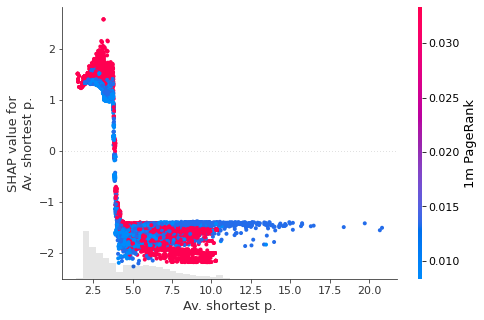

In [50]:
shap.plots.scatter(shap_explanation[:, 'Av. shortest p.'], color=shap_explanation)

<br>
<br>
<br>
<br>
<br>

## Model discriminative power for ER networks

In [125]:
er_data = pd.read_csv('../2_multivariate_analysis/data/pca_sw_robust_example.csv')

In [126]:
er_data.head()

,Assortativity,Transitivity,Av. shortest p.,Complexity Coef,1m Degree,2m Degree,3m Degree,4m Degree,H Degree,1m L. clustering,...,2m Eigenvector,3m Eigenvector,4m Eigenvector,H Eigenvector,len,method,net id,Component0,Component1,Component2
0,-0.039973,0.157171,2.840535,10.302000,10.000000,103.020000,1091.300000,11870.100000,0.850265,0.163492,...,0.003333,0.000203,0.000013,0.000000,300,Original,0,-1.574966,0.884166,0.351172
1,-0.560685,0.246094,2.489655,6.688889,3.000000,20.066667,180.400000,1737.266667,0.603166,0.277037,...,0.033333,0.010541,0.003725,0.466182,30,SB,0,0.689053,1.877014,-0.175949
2,-0.171123,0.109091,6.255172,2.666667,2.200000,5.866667,19.800000,83.466667,0.423581,0.116667,...,0.033333,0.013073,0.006069,0.507119,30,RWS,0,1.391534,-0.159341,0.260530
3,0.031224,0.202247,3.958621,3.170732,2.733333,8.666667,31.333333,126.666667,0.569373,0.187778,...,0.033333,0.010213,0.003504,0.554222,30,IRWS,0,0.748244,0.555013,0.503189
4,0.212894,0.065217,4.574713,2.533333,2.000000,5.066667,15.800000,57.466667,0.508030,0.020000,...,0.033333,0.012254,0.005203,0.527188,30,TR,0,1.112980,0.005665,0.126799


In [127]:
subpop_data = er_data[(er_data['method']=='RWS') | (er_data['method']=='SB')].copy()
#subpop_data = data
#subpop_data = subpop_data[subpop_data['len']==120]

In [128]:
def method_map(row)->int:
    if row['method']=='RWS':
        return 1
    return 0

In [129]:
subpop_data['indicator'] = subpop_data.apply(lambda row: method_map(row), axis=1)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [130]:
subpop_data.shape

(15000, 51)

In [131]:
X = subpop_data[['Assortativity', 'Complexity Coef', '1m Degree', '2m Degree', '3m Degree', '4m Degree', 'H Degree']]
# X = subpop_data[['Component0', 'Component1', 'Component2']]
# X = subpop_data.drop(['Component0', 'Component1', 'Component2', 'net id', 'method', 'len', 'indicator'], axis=1)
y = subpop_data['indicator']

In [132]:
y_pred = np.round(model.predict_proba(X)[:, 1], 5)

In [133]:
gini_score(y, y_pred)

0.9999999999999998

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

In [51]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import random as rd
import math
import altair as alt

from scipy.stats import entropy
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

In [68]:
import catboost
import shap
import sklearn

In [69]:
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool, cv
from sklearn.metrics import make_scorer, roc_auc_score

In [70]:
def gini_score(expected, predicted, **unused_kwargs) -> float:
    return abs(roc_auc_score(expected, predicted)-0.5)*2.0

In [71]:
data_ba = pd.read_csv('../2_multivariate_analysis/data/pca_ba_robust_example.csv')
data_ba['type'] = 'BA'

data_er = pd.read_csv('../2_multivariate_analysis/data/pca_er_robust_example.csv')
data_er['type'] = 'ER'

data_sw = pd.read_csv('../2_multivariate_analysis/data/pca_sw_robust_example.csv')
data_sw['type'] = 'SW'

data_maier = pd.read_csv('../2_multivariate_analysis/data/pca_meier_robust_example.csv')
data_maier['type'] = 'Maier'

In [72]:
data_base = pd.concat([data_ba, data_er, data_sw, data_maier], axis=0)

In [73]:
data_base.shape

(150031, 51)

In [74]:
# list(zip(['BA', 'ER', 'SW', 'Meier'], [30,75,120]))
import itertools

combinations_list = list(itertools.product(['BA', 'ER', 'SW', 'Maier'], [30,75,120]))

In [75]:
for method_train, size_train in combinations_list:
    print(method_train, size_train)

BA 30
BA 75
BA 120
ER 30
ER 75
ER 120
SW 30
SW 75
SW 120
Maier 30
Maier 75
Maier 120


In [76]:
simulations = []

In [77]:
for method_train, size_train in combinations_list:
    
    train = {'types': [method_train],
             'sizes': [size_train]}
    
    for method_test, size_test in combinations_list:
        
        if method_train == method_test and size_train == size_test:
            continue
        
        test  = {'types': [method_test],
                 'sizes': [size_test]}
        
        simulation = {'train': train,
                      'test': test}

        simulations.append(simulation)

In [78]:
len(simulations)

132

In [79]:
# simulations

In [80]:
def simulator(data, simulations, method0, method1):
    
    simulation_results = []
    
    counter = 0
    total = len(simulations)
    
    for simulation in simulations:
        
        train = simulation['train']
        test = simulation['test']
    
        train_data = data[(data['type'].isin(train['types'])) & (data['len'].isin(train['sizes']))]
        test_data = data[(data['type'].isin(test['types'])) & (data['len'].isin(test['sizes']))]

        subpop_data = train_data[(train_data['method']==method1) | (train_data['method']==method0)].copy()
        
        subpop_data['indicator'] = subpop_data['method'].apply(lambda x: 1 if x==method1 else 0)

        # X = subpop_data[['Assortativity', 'Complexity Coef', '1m Degree', '2m Degree', '3m Degree', '4m Degree', 'H Degree']]
        # X = subpop_data[['Component0', 'Component1', 'Component2']]
        X = subpop_data.drop(['Component0', 'Component1', 'Component2', 'net id', 'method', 'len', 'indicator', 'type'], axis=1)
        y = subpop_data['indicator']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)
        X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

        train_pool = Pool(X_train, y_train)
        
        model = CatBoostClassifier(
            thread_count=3,
            iterations=1000,
            learning_rate=.015,
            depth=5.0,
            l2_leaf_reg=0.550,
            min_child_samples=10.0,
            grow_policy='SymmetricTree',
            loss_function='Logloss',
            eval_metric='Logloss',
            # eval_metric='AUC:hints=skip_train~false',
            od_type='Iter',
            bootstrap_type='Bayesian',
            auto_class_weights='Balanced',
            
            silent=True
        ).fit(
            train_pool,
            early_stopping_rounds=100,
            eval_set=Pool(X_valid, y_valid),
            save_snapshot=False
        )

        y_pred = np.round(model.predict_proba(X_test)[:, 1], 5)    
        # print('\n\ntrain: ', gini_score(y_test, y_pred))
        
        train_gini = gini_score(y_test, y_pred)


        subpop_data = test_data[(test_data['method']==method1) | (test_data['method']==method0)].copy()
        
        subpop_data['indicator'] = subpop_data['method'].apply(lambda x: 1 if x==method1 else 0)

        # X = subpop_data[['Assortativity', 'Complexity Coef', '1m Degree', '2m Degree', '3m Degree', '4m Degree', 'H Degree']]
        # X = subpop_data[['Component0', 'Component1', 'Component2']]
        X = subpop_data.drop(['Component0', 'Component1', 'Component2', 'net id', 'method', 'len', 'indicator', 'type'], axis=1)
        y = subpop_data['indicator']

        y_pred = np.round(model.predict_proba(X)[:, 1], 5)
        # print('test: ', gini_score(y, y_pred))
        
        test_gini = gini_score(y, y_pred)
        
        
        result = {'train_type': train['types'],
                  'train_size': train['sizes'],
                  'test_type': test['types'],
                  'test_size': test['sizes'],
                  'train_gini': train_gini,
                  'test_gini': test_gini}
        
        simulation_results.append(result)
        
        del result
        del subpop_data
        del train_data
        del test_data
        
        counter = counter + 1
        
        print('\nCompleteness: ', np.round(counter/total, 2))
        
        
    return simulation_results

In [81]:
results = simulator(data_base, simulations, method0='RWS', method1='MHRW')


Completeness:  0.01

Completeness:  0.02

Completeness:  0.02

Completeness:  0.03

Completeness:  0.04

Completeness:  0.05

Completeness:  0.05

Completeness:  0.06

Completeness:  0.07

Completeness:  0.08

Completeness:  0.08

Completeness:  0.09

Completeness:  0.1

Completeness:  0.11

Completeness:  0.11

Completeness:  0.12

Completeness:  0.13

Completeness:  0.14

Completeness:  0.14

Completeness:  0.15

Completeness:  0.16

Completeness:  0.17

Completeness:  0.17

Completeness:  0.18

Completeness:  0.19

Completeness:  0.2

Completeness:  0.2

Completeness:  0.21

Completeness:  0.22

Completeness:  0.23

Completeness:  0.23

Completeness:  0.24

Completeness:  0.25

Completeness:  0.26

Completeness:  0.27

Completeness:  0.27

Completeness:  0.28

Completeness:  0.29

Completeness:  0.3

Completeness:  0.3

Completeness:  0.31

Completeness:  0.32

Completeness:  0.33

Completeness:  0.33

Completeness:  0.34

Completeness:  0.35

Completeness:  0.36

Completeness:  0.

In [82]:
results = pd.DataFrame(results)